In [14]:
import torch as t
import torchmetrics
from DiagnosisAI.utils.metrics import calculate_type_errors, calc_metrics
from DiagnosisAI.models.resnet3d import generate_model
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pickle
from torch.utils import data
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import nipy
from nibabel.testing import data_path
from DiagnosisAI.datasets_torch.brain_3d_dataset import Brain3DDataset
from tqdm import tqdm
from scipy.ndimage import zoom
from sklearn.cluster import KMeans
import nibabel as nib
from DiagnosisAI.utils.utils_function import get_max_area_slice
from pathlib import Path
from torchvision.transforms import ToTensor
import gc
from sklearn.model_selection import train_test_split
import matplotlib

In [2]:
batch_size = 1
num_workers = 4
train_size = 0.7
seed = 42
device = t.device('cuda')
dataset_root_path = "../datasets/brain/Brats2021_training_df/"

In [3]:
def __get_filenames_from_dir__(path:str):
    filenames = []
    for dir in Path(path).iterdir():
        filenames.append(dir)
    return filenames

test_size = 1 - train_size
filenames = __get_filenames_from_dir__(dataset_root_path)
train_names, val_names = train_test_split(filenames, test_size=test_size, random_state=seed)
val_names, test_names = train_test_split(val_names, test_size=0.5, random_state=seed)

# ======== LOAD DATA ===========
print("Loading datasets")
train_dataset = Brain3DDataset(train_names, t1ce=True)
val_dataset = Brain3DDataset(val_names, t1ce=True)
test_dataset = Brain3DDataset(test_names, t1ce=True)

train_loader = t.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_loader = t.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = t.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

img, label = next(iter(train_loader))
print("Shapes:")
print(f"Input img: {img.shape},  Label: {label.shape}")

Loading datasets
Shapes:
Input img: torch.Size([1, 1, 28, 28, 28]),  Label: torch.Size([1, 1, 28, 28, 28])


In [4]:
device = t.device('cuda')
network = generate_model(model_depth=18, n_classes=11, n_input_channels=1)
model_state_path = "../trainings/model_states/classif_3d/resnet18/model_state"
network.load_state_dict(t.load(model_state_path, map_location=device))
embedd_network = nn.Sequential(*list(network.children())[:-1])
embedd_network.eval()


Sequential(
  (0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

In [5]:
embeddings = []
t1ce_images = []
labels = []
for i, (img, label) in enumerate(tqdm(test_dataset)):
    with t.no_grad():
        output = embedd_network(img.unsqueeze(0))
        output = output[-1]
        output = nn.AdaptiveAvgPool2d(output_size=(1, 1))(output)
        output = output.squeeze().numpy()
        output = output.reshape(1, -1)

    embeddings.append(output)
    t1ce_images.append(img.numpy())
    labels.append(label.numpy())

    del output

embeddings = np.array(embeddings)

100%|██████████| 188/188 [03:29<00:00,  1.12s/it]


In [6]:
embeddings = embeddings.squeeze()

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.001s...
[t-SNE] Computed neighbors for 188 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 990.892942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.156845
[t-SNE] KL divergence after 700 iterations: 0.067957


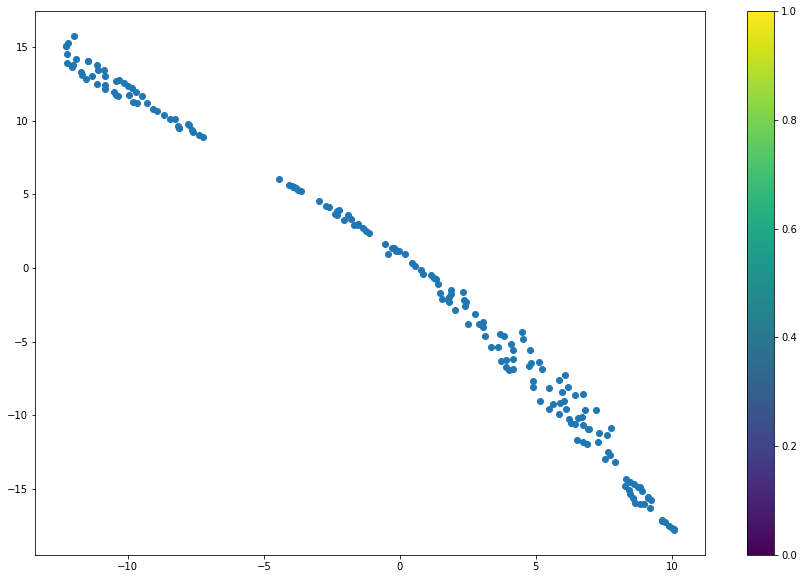

In [29]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean', random_state=42).fit_transform(embeddings)
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()

In [17]:
def find_case(case_folder: str):
    sample = None
    seg = None
    for filename_path in case_folder.iterdir():
        if 't1ce' in filename_path.name:
            sample = nib.load(filename_path).get_fdata().copy()
        if 'seg' in filename_path.name:
            seg = nib.load(filename_path).get_fdata().copy()
            seg = np.where(seg >=1, 1, 0)

    return sample, seg

In [18]:
neighbors = NearestNeighbors(n_neighbors=len(embeddings), algorithm='brute', metric='euclidean').fit(embeddings)
distances, indices = neighbors.kneighbors([embeddings[133]])
indices = indices.flatten()

k_nearest = indices[0:5]
nearest_dist = distances.flatten()[0:5]
k_furthest = indices[-5:][::-1]
furthest_dist = distances.flatten()[-5:][::-1]

In [19]:
simillar_images = [find_case(test_names[idx]) for idx in k_nearest]
no_simillar_images = [find_case(test_names[idx]) for idx in k_furthest]
simillar_max_slice = [get_max_area_slice(find_case(test_names[idx])[1]) for idx in k_nearest]
no_simillar_max_slice = [get_max_area_slice(find_case(test_names[idx])[1]) for idx in k_furthest]

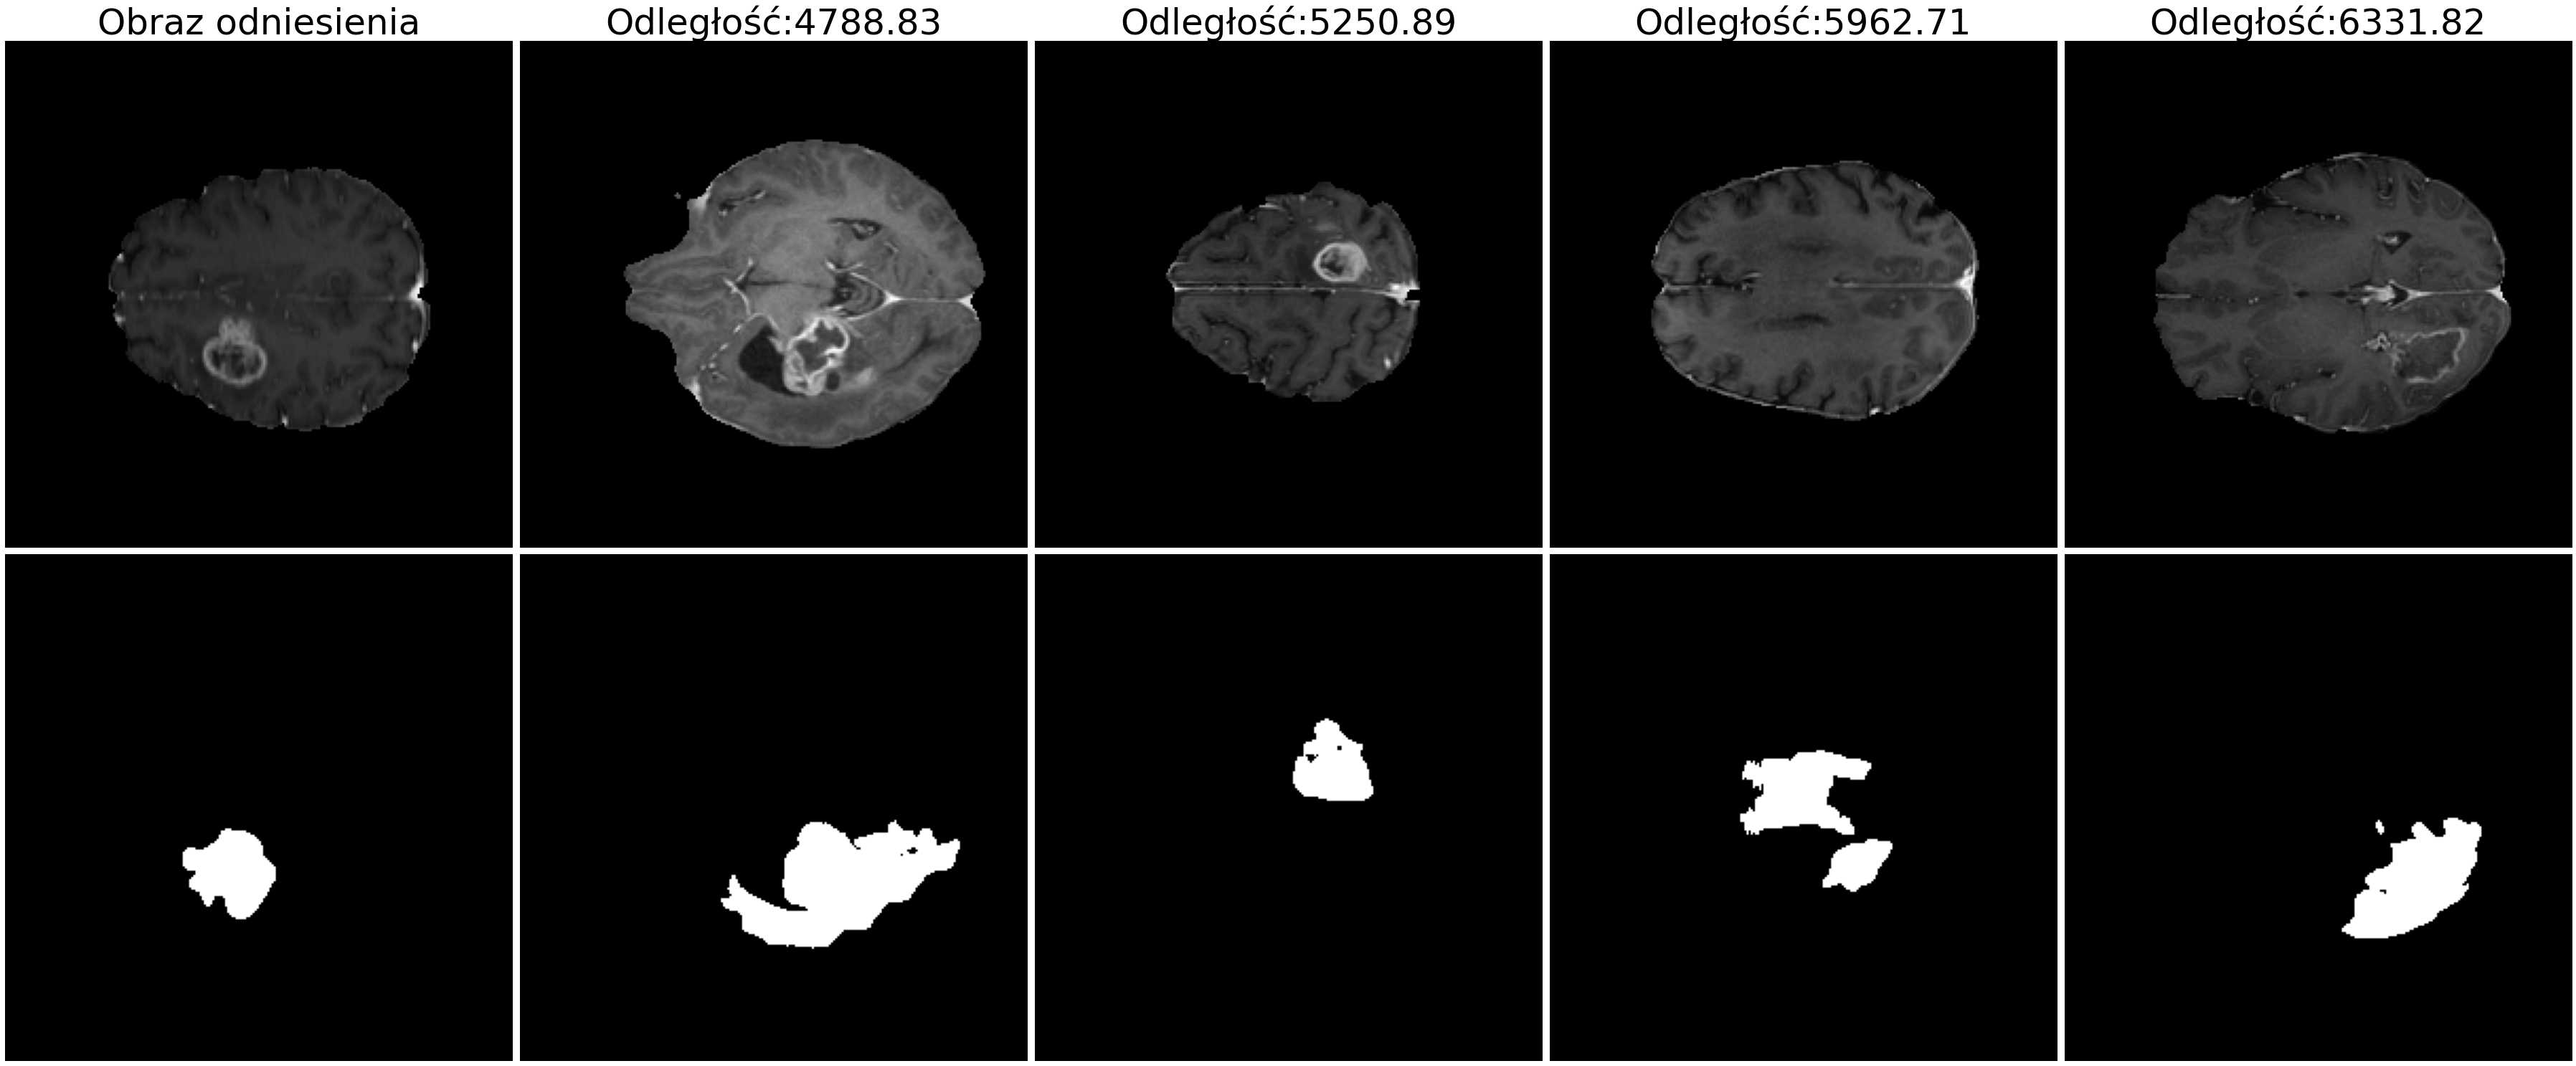

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 21))
for i, idx in enumerate(k_nearest):
    ax[0, i].imshow(simillar_images[i][0][:, :, simillar_max_slice[i]], cmap='gray')
    ax[1, i].imshow(simillar_images[i][1][:, :, simillar_max_slice[i]], cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(nearest_dist.tolist()[i], 2)}', size=50)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
ax[0, 0].set_title('Obraz odniesienia', size=50)
fig.tight_layout()

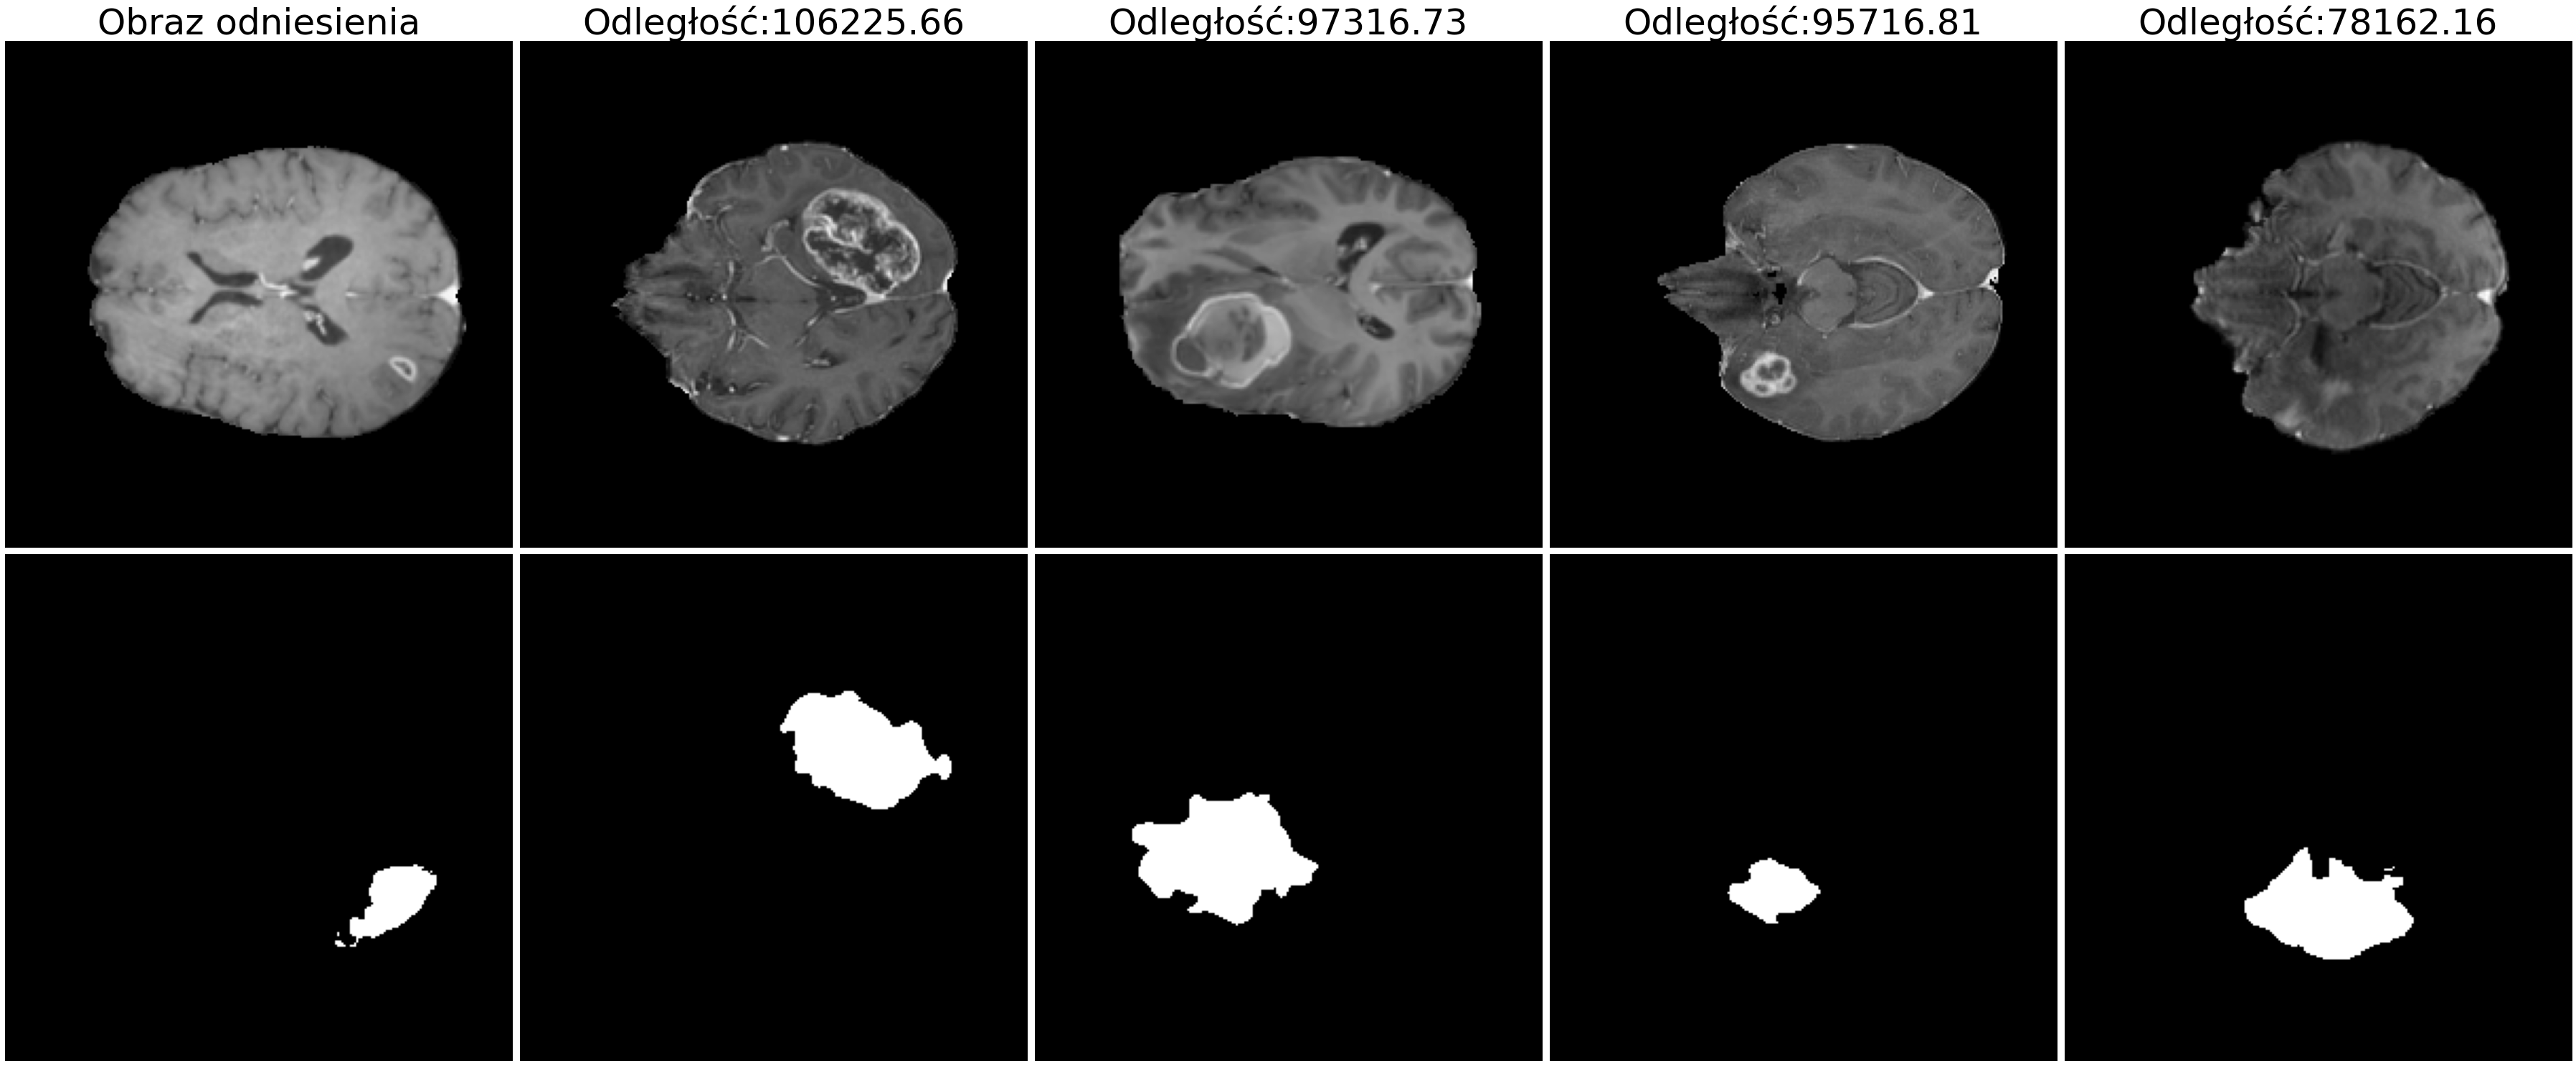

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 21))
for i, idx in enumerate(k_furthest):
    ax[0, i].imshow(no_simillar_images[i][0][:, :, no_simillar_max_slice[i]], cmap='gray')
    ax[1, i].imshow(no_simillar_images[i][1][:, :, no_simillar_max_slice[i]], cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(furthest_dist.tolist()[i], 2)}', size=50)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
ax[0, 0].set_title('Obraz odniesienia', size=50)
fig.tight_layout()

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.001s...
[t-SNE] Computed neighbors for 188 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 990.892942
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.156845
[t-SNE] KL divergence after 700 iterations: 0.067957


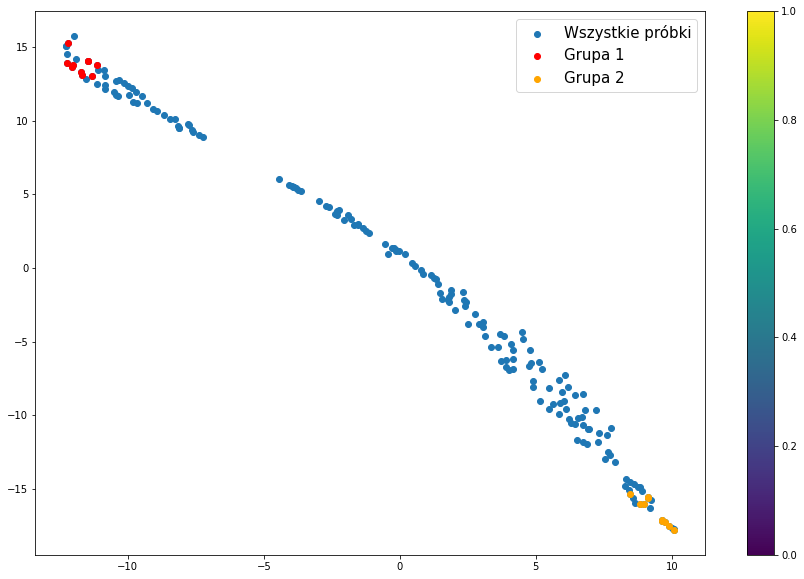

In [28]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean', random_state=42).fit_transform(embeddings)
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], cmap=plt.cm.get_cmap('coolwarm'))
plt.scatter(tsne_results[:, 0][group1], tsne_results[:,1][group1], color='red')
plt.scatter(tsne_results[:, 0][group2], tsne_results[:,1][group2], color='orange')
plt.legend(['Wszystkie próbki', 'Grupa 1', 'Grupa 2'], loc=0, prop={'size': 15})
plt.colorbar()

In [27]:
group1 = np.array(np.where((tsne_results[:, 0] < -11) & (tsne_results[:, 1] > 13))).flatten()[0:10]
group2 = np.array(np.where((tsne_results[:, 0] > 8) & (tsne_results[:, 1] < -15))).flatten()[0:10]

In [58]:
group1_images = [find_case(test_names[idx]) for idx in group1]
group2_images = [find_case(test_names[idx]) for idx in group2]
group1_max_slice = [get_max_area_slice(find_case(test_names[idx])[1]) for idx in group1]
group2_max_slice = [get_max_area_slice(find_case(test_names[idx])[1]) for idx in group2]

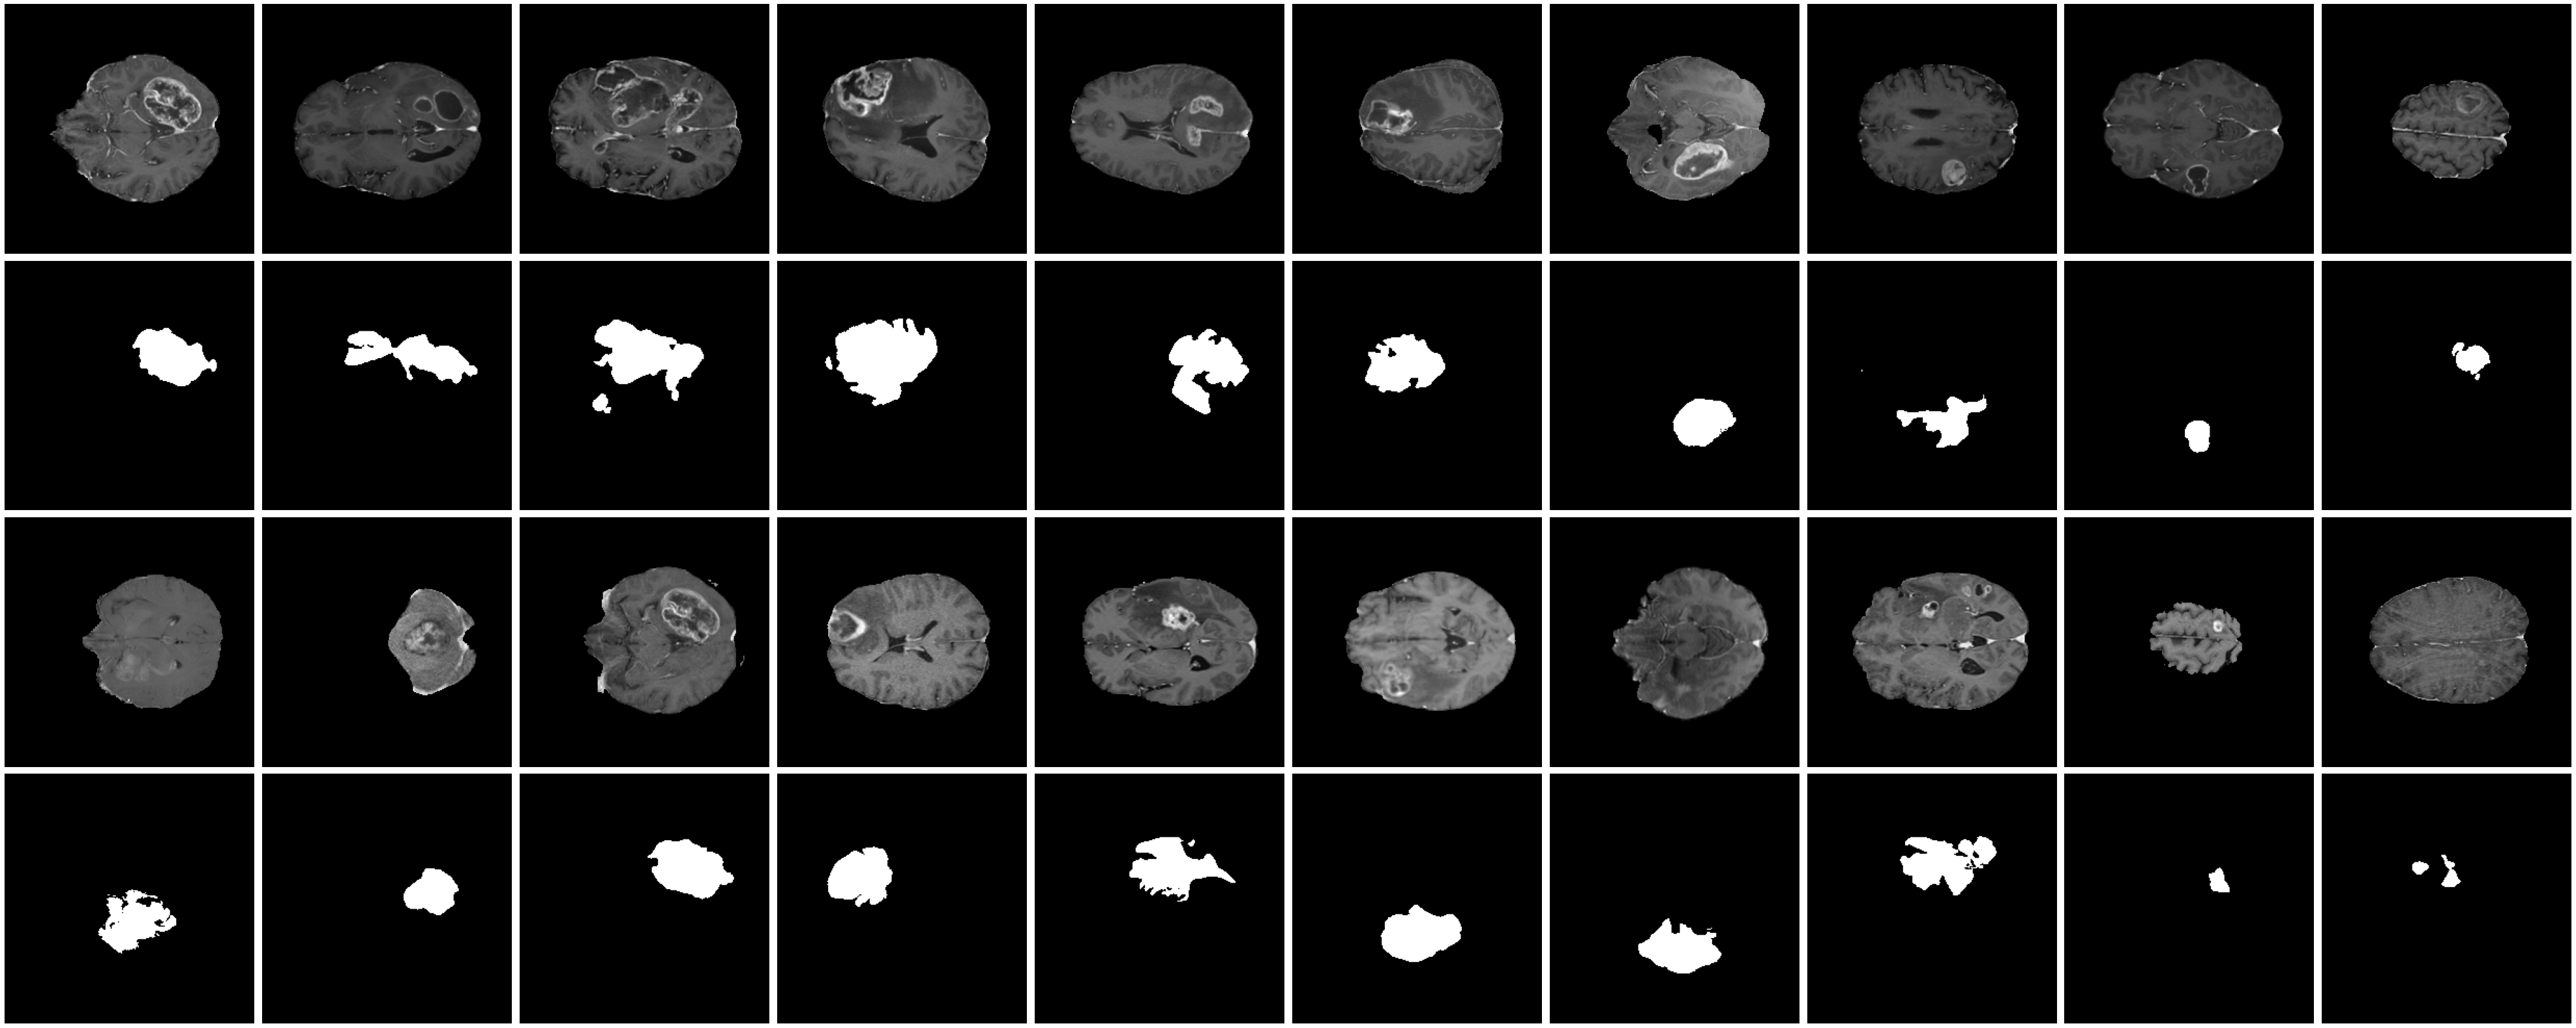

In [68]:
fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(55, 22))
for i in range(10):
    ax[0, i].imshow(group1_images[i][0][:, :, group1_max_slice[i]], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(group1_images[i][1][:, :, group1_max_slice[i]], cmap='gray')
    ax[1, i].axis('off')
    ax[2, i].imshow(group2_images[i][0][:, :, group2_max_slice[i]], cmap='gray')
    ax[2, i].axis('off')
    ax[3, i].imshow(group2_images[i][1][:, :, group2_max_slice[i]], cmap='gray')
    ax[3, i].axis('off')
fig.tight_layout()